In [7]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [2]:
# for numercial computing in python and multiple dimension array | and plot
import mne
import numpy as np
import matplotlib.pyplot as plt

# Import the maching learning tools
# import pipeline for create a sequence of data processing steps in a pipeline.
# pipeline to combine all the models together and to extract the features | LDA for classification|model_selection for split the data sets
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# mne package for import the tools for processing EEG data
from mne import Epochs, pick_types, events_from_annotations
'''
Epochs is used for extracting short segements from continuous EEG recordings, typically around specific events
pick_types is used to select specific types of EEG chennels (usually pick the good channels from the bad channels)
events_from_annotations is used to extract events from annotations in EEG data
'''
# for reading sensor layout imformation
from mne.channels import read_layout, make_standard_montage

# for reading and concatenating EEG data | concatenate for combine multiple EEG recordings | read EEG data in the edf format
from mne.io import concatenate_raws, read_raw_edf

# imports the EEGBCI dataset from MNE, a dataset that is public free and can be download through MNE website
from mne.datasets import eegbci
# import Common Spatial Patterns, which is a technique for extracting features from EEG signals
from mne.decoding import CSP

In [26]:
raw = read_raw_edf("files/S001/S001R03.edf",preload = False)


Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [30]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events_from_annot)


Used Annotations descriptions: ['T0', 'T1', 'T2']
{'T0': 1, 'T1': 2, 'T2': 3}
[[    0     0     1]
 [  672     0     3]
 [ 1328     0     1]
 [ 2000     0     2]
 [ 2656     0     1]
 [ 3328     0     2]
 [ 3984     0     1]
 [ 4656     0     3]
 [ 5312     0     1]
 [ 5984     0     3]
 [ 6640     0     1]
 [ 7312     0     2]
 [ 7968     0     1]
 [ 8640     0     2]
 [ 9296     0     1]
 [ 9968     0     3]
 [10624     0     1]
 [11296     0     2]
 [11952     0     1]
 [12624     0     3]
 [13280     0     1]
 [13952     0     3]
 [14608     0     1]
 [15280     0     2]
 [15936     0     1]
 [16608     0     2]
 [17264     0     1]
 [17936     0     3]
 [18592     0     1]
 [19264     0     2]]


In [32]:
custom_mapping = {'T1':2,'T2':3}
(events_from_annot,event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
print(events_from_annot)
print(event_dict)


Used Annotations descriptions: ['T1', 'T2']
[[  672     0     3]
 [ 2000     0     2]
 [ 3328     0     2]
 [ 4656     0     3]
 [ 5984     0     3]
 [ 7312     0     2]
 [ 8640     0     2]
 [ 9968     0     3]
 [11296     0     2]
 [12624     0     3]
 [13952     0     3]
 [15280     0     2]
 [16608     0     2]
 [17936     0     3]
 [19264     0     2]]
{'T1': 2, 'T2': 3}


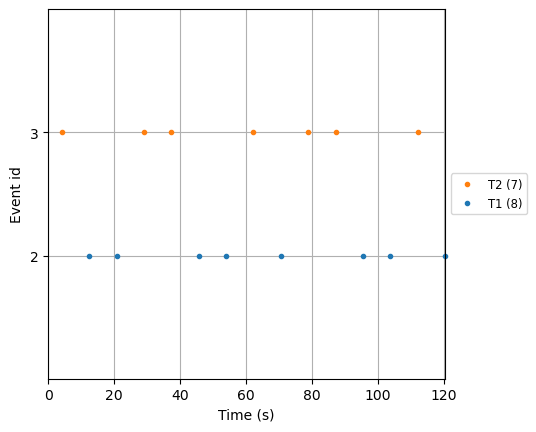

In [33]:
fig = mne.viz.plot_events(events_from_annot, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)


# 筛选需要的数据项目，保留左右手运动想象测试数据

In [3]:
import os
import string

def loop(path):
    specific_endings = ['03','04','07','08','11','12']

    matched_files = []
    files = os.listdir(path)
    
    for root,dirs,files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1] == '.edf' and any((file.endswith(ending +'.edf')) for ending in specific_endings):
                matched_files.append(os.path.join(root,file))

    return matched_files

def out_loop(path):
    files = os.listdir(path)
    all_matched_files = []
    for root,dirs,files in os.walk(path):
        for dir in dirs:
            all_matched_files.append(loop(os.path.join(root,dir)))
    return all_matched_files

def find_all():
    directory_path = '/Users/calvin-xu/Desktop/MEng 4th year Project/Software/files'
    all_files = out_loop(directory_path)
    lst = []

    for file in all_files:
        for c in file:
            lst.append(c)

    return lst

all_roots = find_all()
all_roots

def create_raw(edf_path):
    raws = []
    for path in edf_path:
        raw = mne.io.read_raw_edf(path,preload=True)
        raws.append(raw)
    return raws




In [11]:
# for numercial computing in python and multiple dimension array | and plot
import os
import numpy as np
import matplotlib.pyplot as plt

# Import the maching learning tools
# import pipeline for create a sequence of data processing steps in a pipeline.
# pipeline to combine all the models together and to extract the features | LDA for classification|model_selection for split the data sets
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# mne package for import the tools for processing EEG data
from mne import Epochs, pick_types, events_from_annotations
'''
Epochs is used for extracting short segements from continuous EEG recordings, typically around specific events
pick_types is used to select specific types of EEG chennels (usually pick the good channels from the bad channels)
events_from_annotations is used to extract events from annotations in EEG data
'''
# for reading sensor layout imformation
from mne.channels import read_layout, make_standard_montage

# for reading and concatenating EEG data | concatenate for combine multiple EEG recordings | read EEG data in the edf format
from mne.io import concatenate_raws, read_raw_edf

# import Common Spatial Patterns, which is a technique for extracting features from EEG signals
from mne.decoding import CSP



###############################################################################
tmin, tmax = -1., 4.  #设置参数，记录点的前1秒后4秒用于生成epoch数据
event_id = dict(left=2, right=3) #设置事件的映射关系, what "hands" movements are mapped to 2 and "feet" movements are mapped to 3
runs = range(1,10) # 指定要从受试者中夹菜哪些运行运行或者会话的数据。这边指的是运行 6 10 14 会话数据。


# 获取想要读取的文件名称，这个应该是没有会默认下载的数据
# mne.datasets.eegbci.load_data(subject, runs, path=None, force_update=False, update_path=None, base_url='https://physionet.org/files/eegmmidb/1.0.0/', verbose=None)
# raw_fnames 找到了所有需要进行训练的名单
raw_fnames = all_roots
# raw_list 通过这些名单找到raw数据 ？？？需要查一下这个变量是什么以及这个函数是什么
raw_list = create_raw(raw_fnames)

# 找到需要测试的sample rate，并将不是这个sample rate的数据修改成desired_sfreq
raws_resampled = []
desired_sfreq = 160
for i,raw in enumerate(raw_list):
    if raw.info['sfreq'] != desired_sfreq:
        raws_resampled.append(raw.resample(desired_sfreq))
    else:
        raws_resampled.append(raw)

# 将所有的raw data合并在一起，前面需要resample的目的是为了将raw合在一起
raw = mne.concatenate_raws(raws_resampled)
# print(raw)

print('----')
channel_names = raw.info
print('the raw before bandpass: \n')
print(channel_names)

eegbci.standardize(raw)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# 去掉通道名称后面的（.），不知道为什么默认情况下raw.info['ch_names']中的通道名后面有的点
raw.rename_channels(lambda x: x.strip('.'))
# 对原始数据进行FIR带通滤波 加一个点的意思是浮点数而不是int 使用浮点数而不是整数对于频率滤波来说可以提高更高的精度
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
# 这里可以看到高通是7Hz，低通是30Hz
print('the raw after bandpass: \n')
print(raw.info)


# 从annotation中获取事件信息
# mne.events_from_annotations(raw, event_id='auto', regexp='^(?![Bb][Aa][Dd]|[Ee][Dd][Gg][Ee]).*$', use_rounding=True, chunk_duration=None, verbose=None)
# regexp 里面的内容通常为正则表达式，用来筛选注释。在这个例子当中，一般用来判处以bad或者edge开头的注释，因为这些通常表示为坏段，边缘等，并不是真正的事件。
# eventid 这个参数是一个字典，用来定义将注释的比如在这边是T1 T2 映射到数值事件（我们之前定义过了）T1 为hands T2 为feet
# 我们之前将手设置为2，将脚设置为3，这行代码的目的就是为了将EEG数据中依据注释提取事件信息，将这些信息转换为事件数组（2，3）
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
# 剔除坏道，提取其中有效的EEG数据
# mne.pick_types(info, meg=False, eeg=False, stim=False, eog=False, ecg=False, emg=False, ref_meg='auto', *, misc=False, resp=False, chpi=False, exci=False, ias=False, syst=False, seeg=False, dipole=False, gof=False, bio=False, ecog=False, fnirs=False, csd=False, dbs=False, temperature=False, gsr=False, eyetrack=False, include=(), exclude='bads', selection=None)
# 函数返回一个包含所选通道的数组，数组包含了选择的通道的编号
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print("(----)")
print(picks)
# 根据事件生成对应的Epochs数据
# class mne.Epochs(raw, events, event_id=None, tmin=-0.2, tmax=0.5, baseline=(None, 0), picks=None, preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, reject_tmax=None, detrend=None, on_missing='raise', reject_by_annotation=True, metadata=None, event_repeated='error', verbose=None)
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)


# 截取其中的1秒到2秒之间的数据，也就是提示音后1秒到2秒之间的数据（这个在后面滑动窗口验证的时候有用）
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
# 将events转换为labels,event为2,3经过计算后也就是0,1
labels = epochs.events[:, -1] - 2



Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S038/S038R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S038/S038R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S038/S038R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 

/var/folders/bh/tllltg9x1mx_qfdv8t8pnh1r0000gn/T/ipykernel_2710/3776957955.py:42: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path,preload=True)
/var/folders/bh/tllltg9x1mx_qfdv8t8pnh1r0000gn/T/ipykernel_2710/3776957955.py:42: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path,preload=True)
/var/folders/bh/tllltg9x1mx_qfdv8t8pnh1r0000gn/T/ipykernel_2710/3776957955.py:42: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path,preload=True)
/var/folders/bh/tllltg9x1mx_qfdv8t8pnh1r0000gn/T/ipykernel_2710/3776957955.py:42: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path,preload=True)
/var/folders/bh/tllltg9x1mx_qfdv8t8pnh1r0000gn/T/ipykernel_2710/3776957955.py:42: RuntimeWarning: Limited 1 annotation(s) that were expanding outsid

Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S106/S106R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S106/S106R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S106/S106R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/calvin-xu/Desktop/MEng 4th year Project/Software/files/S106/S106R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struc

KeyboardInterrupt: 

利用CSP提取特征向量，使用LDA进行分类

<Epochs |  9795 events (all good), -1 – 4 s, baseline off, ~3.74 GB, data loaded,
 'left': 4922
 'right': 4873>
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank

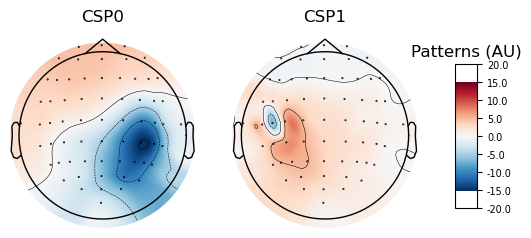

In [8]:
scores = []

print(epochs)
# 获取epochs的所有数据，主要用于后面的滑动窗口验证
epochs_data = epochs.get_data()

# 获取训练数据
epochs_data_train = epochs_train.get_data()

# 设置交叉验证模型的参数
cv = ShuffleSplit(10, test_size=0.2, random_state=42)

# 根据设计的交叉验证参数,分配相关的训练集和测试集数据
cv_split = cv.split(epochs_data_train)

# 创建线性分类器
lda = LinearDiscriminantAnalysis()
svm = SVC(kernel='linear')

# 创建CSP提取特征，这里使用1个分量的CSP
# 这个需要调查一下
csp = CSP(n_components=2, reg=None, log=False, norm_trace=False)

# 创建机器学习的Pipeline,也就是分类模型，使用这种方式可以把特征向量提取和分类统一整合到了clf中
clf = Pipeline([('CSP', csp), ('LDA', lda)])
clf2 = Pipeline([('CSP',csp),('SVM'), svm])

# 获取交叉验证模型的得分
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# 输出结果，准确率和不同样本的占比
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

# csp提取特征,用于绘制CSP不同分量的模式图（地形图）
csp.fit_transform(epochs_data, labels)

filters = csp.filters_
print("filter shape: ", filters.shape)

print("-----")
print(epochs.info)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.9e+10  max singular value)
    Es

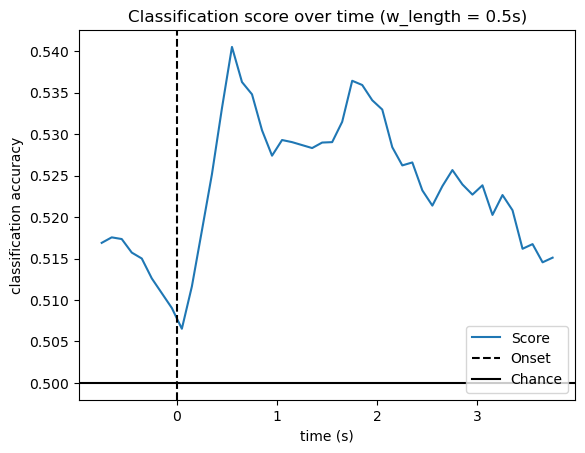

In [6]:
# 获取数据的采样频率
sfreq = raw.info['sfreq']
# 设置滑动窗口的长度，也就是数据窗口的长度
w_length = int(sfreq * 0.5)
# 设置滑动步长，每次滑动的数据间隔
w_step = int(sfreq * 0.1)
# 每次滑动窗口的起始点
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
# 得分列表用于保存模型得分
scores_windows = []
# 交叉验证计算模型的性能
for train_idx, test_idx in cv_split:
    # 获取测试集和训练集数据
    y_train, y_test = labels[train_idx], labels[test_idx]
    # 设置csp模型的参数，提取相关特征，用于后面的lda分类
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    # 拟合lda模型
    lda.fit(X_train, y_train)
    # 用于记录本次交叉验证的得分
    score_this_window = []
    for n in w_start:
        # csp提取测试数据相关特征
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        # 获取测试数据得分
        score_this_window.append(lda.score(X_test, y_test))
    # 添加到总得分列表
    scores_windows.append(score_this_window)
 
# 设置绘图的时间轴，时间轴上的标志点为窗口的中间位置
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
# 绘制模型分类结果的性能图（得分的均值）
plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time (w_length = {0}s)'.format(w_length/sfreq))
plt.legend(loc='lower right')
plt.show()